In [173]:
"""from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks  """

"from google.colab import drive\ndrive.mount('/content/drive')\n%cd /content/drive/My\\ Drive/Colab\\ Notebooks  "

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from sklearn  import preprocessing, decomposition, base
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.model_selection import RandomizedSearchCV, cross_validate, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, make_scorer, roc_curve, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from datetime import datetime

from IPython.display import display
pd.options.display.max_columns = 25

import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_importance
import time

os.getcwd()

'/Users/federicofrancone/Desktop/final_insurance_data/No_validation/Experiments'

In [209]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']


def title_ticks_ecc(title, xlabel, ylabel, new_fig= True , figsize= (10,6)):
    if new_fig== True:
        plt.figure(figsize=figsize)
        
    plt.title(title, color='red', fontsize= 18, pad= 13)
    plt.xlabel(xlabel, color='red', fontsize= 14)
    plt.ylabel(ylabel, color='red', fontsize= 14)
    plt.xticks(fontsize=12, color='blue')
    plt.yticks(fontsize=12, color='blue')

In [175]:
binned_train = pd.read_csv('../../df_train_high_g_pre_bin2.csv')  #1166
binned_test = pd.read_csv('../../df_test_high_g_pre_bin2.csv')

target= ytrain=  binned_train['target']
target_test= ytest= binned_test['target']

target_distribution= round(target.value_counts()*100/len(binned_train),2)
target_distribution

0    88.15
1    11.85
Name: target, dtype: float64

In [176]:
target.shape, target_test.shape

((96399,), (41312,))

In [279]:
pred_gbm_train= pd.read_csv('../Predictions/Pred_gbm_train.csv')['0']
pred_gbm_test= pd.read_csv('../Predictions/Pred_gbm_test.csv')['0']

pred_xgb_train= pd.read_csv('../Predictions/Pred_xgb_train.csv')['0']
pred_xgb_test= pd.read_csv('../Predictions/Pred_xgb_test.csv')['0']

pred_log_train= pd.read_csv('../Predictions/Pred_log_train.csv')['0']
pred_log_test= pd.read_csv('../Predictions/Pred_log_test.csv')['0']

pred_cat_train= pd.read_csv('../Predictions/Pred_catboost_train.csv')['0']
pred_cat_test= pd.read_csv('../Predictions/Pred_catboost_test.csv')['0']

### Benchmark AUC scores

In [280]:
####### GBM ##########
auc_tr_gbm= round(roc_auc_score(ytrain, pred_gbm_train), 4)
auc_test_gbm= round(roc_auc_score(ytest, pred_gbm_test), 4)

auc_tr_cat= round(roc_auc_score(ytrain, pred_cat_train), 4)
auc_test_cat= round(roc_auc_score(ytest, pred_cat_test), 4)

print('AUC scores GBM:', auc_tr_gbm, auc_test_gbm)
print('AUC scores Catboost:', auc_tr_cat, auc_test_cat)

AUC scores GBM: 0.7409 0.723
AUC scores Catboost: 0.7335 0.7242


In [188]:
pred_gbm_train.describe(percentiles= np.arange(0, 0.91, 0.1))

count    96399.000000
mean         0.118516
std          0.091610
min          0.011415
0%           0.011415
10%          0.039780
20%          0.052502
30%          0.063723
40%          0.074611
50%          0.088657
60%          0.108253
70%          0.129061
80%          0.159093
90%          0.269911
max          0.609747
Name: 0, dtype: float64

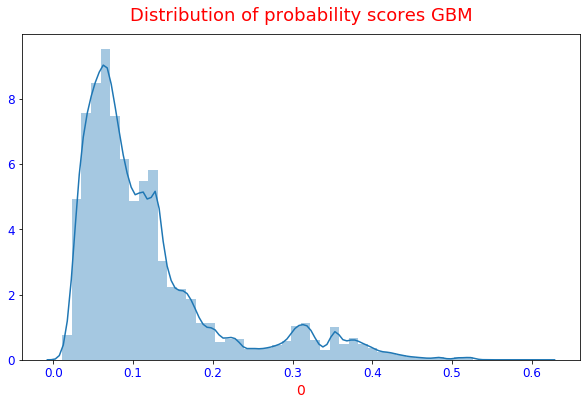

In [189]:
title_ticks_ecc('Distribution of probability scores GBM', 'Probability', '')
sns.distplot(pred_gbm_train)

In [201]:
df_probs = pd.DataFrame(pd.Series(pred_gbm_train.values))
df_probs['label'] = target.values
df_probs.columns= ['proba', 'label' ]

df_probs.head()

,proba,label
0,0.211812,0
1,0.269010,0
2,0.079756,0
3,0.037739,0
4,0.049673,0


### Optimal Threshold

In [213]:
fpr, tpr, thresholds = roc_curve(ytrain, df_probs['proba'], pos_label=1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
pred_proba_df = pd.DataFrame(df_probs['proba'])
p= optimal_preds = pred_proba_df.applymap(lambda x: 1 if x>optimal_threshold else 0)
print('Optimal threshold: {0:3.3f}'.format(optimal_threshold))

Optimal threshold: 0.114


In [172]:
print(classification_report(ytrain, p))

confusion_matrix(ytrain, p)

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     84975
           1       0.22      0.66      0.33     11424

    accuracy                           0.68     96399
   macro avg       0.58      0.67      0.56     96399
weighted avg       0.85      0.68      0.74     96399



array([[57958, 27017],
       [ 3828,  7596]])

### Analysis of Youden Statistic

In [99]:
youden_stat= pd.Series(tpr - fpr, index= thresholds)
youden_stat.describe()

count    16579.000000
mean         0.252983
std          0.092757
min         -0.000012
25%          0.193674
50%          0.290177
75%          0.331344
max          0.347063
dtype: float64

In [100]:
lb= youden_stat.std()

In [101]:
youden_stat

1.609747    0.000000
0.609747   -0.000012
0.540077    0.000338
0.539719    0.000327
0.523729    0.000414
              ...   
0.014432    0.000365
0.014355    0.000341
0.013114    0.000082
0.012803    0.000059
0.011415    0.000000
Length: 16579, dtype: float64

(0, 0.6)

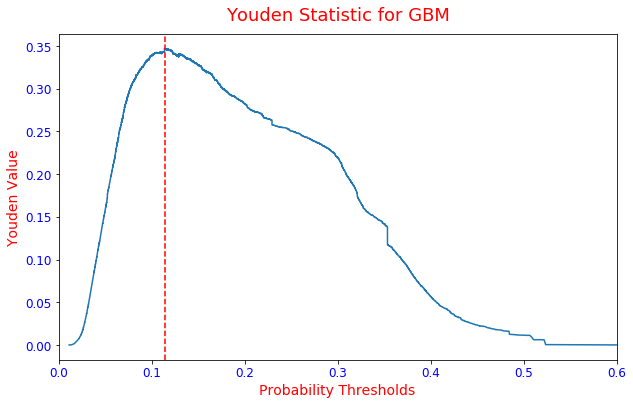

In [127]:
title_ticks_ecc('Youden Statistic for GBM', 'Probability Thresholds', 'Youden Value')
youden_stat.plot()
plt.axvline(optimal_threshold , color= 'red', linestyle= '--', label= 'Optimal point')
plt.xlim(0, 0.6)

In [ ]:
prova= youden_stat[youden_stat > 0.25].index
pred_gbm_test[ (pred_gbm_test > prova.min()) & (pred_gbm_test < prova.max())].shape

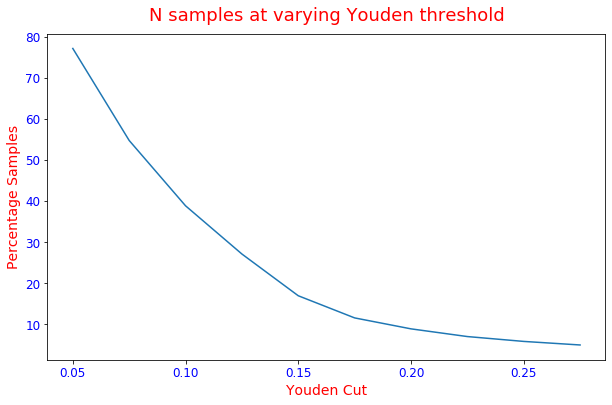

In [136]:
l= []
thresh= np.arange(0.05, 0.3, 0.025)

for i in thresh:
    index= youden_stat[youden_stat > i]
    min_prob= index.min()
    max_prob= index.max()
    perc_samples= pred_gbm_train[ (pred_gbm_train > min_prob) & (pred_gbm_train < max_prob)].shape[0]*100/ len(ytrain)
    l.append(perc_samples)

title_ticks_ecc('N samples at varying Youden threshold', 'Youden Cut', 'Percentage Samples',)
plt.plot(thresh, l)

### Finding Interval of uncertainty based on distribution of scores in respect to labels

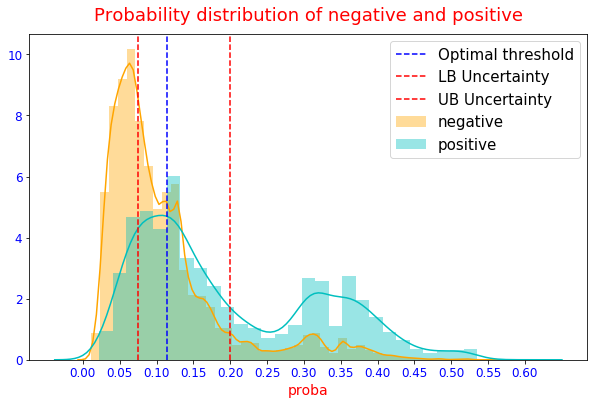

In [204]:
neg= df_probs[df_probs['label'] == 0]
pos= df_probs[df_probs['label'] == 1]

title_ticks_ecc('Probability distribution of negative and positive', '', '')
sns.distplot(neg['proba'], color= 'orange', label= 'negative')
sns.distplot(pos['proba'], color= 'c', label= 'positive')

plt.axvline(optimal_threshold , color= 'blue', linestyle= '--', label= 'Optimal threshold')

plt.axvline(0.2 , color= 'red', linestyle= '--', label= 'LB Uncertainty')
plt.axvline(0.075 , color= 'red', linestyle= '--', label= 'UB Uncertainty')

plt.xticks(np.arange(0, 0.61, 0.05))
plt.legend(fontsize= 15)

#### 1st visual attempt of defining uncertainty intervals

In [218]:
lb= 0.075
ub= 0.2

left_interval = pred_gbm_train[(pred_gbm_train> lb) & (pred_gbm_train<optimal_threshold)]
right_interval = pred_gbm_train[(pred_gbm_train>optimal_threshold) & (pred_gbm_train<ub)]

left_interval.shape[0], right_interval.shape[0], left_interval.shape[0]+ right_interval.shape[0]

(22963, 21379, 44342)

In [225]:
samples_interval= set(left_interval.index).union(right_interval.index)
len(samples_interval)

inside_interval= df_probs.loc[samples_interval]
outside_interval= df_probs[df_probs.index.isin(samples_interval)==False]

inside_interval.shape[0], outside_interval.shape[0], inside_interval.shape[0]+outside_interval.shape[0],

(44342, 52057, 96399)

In [228]:
opt_preds_inside= optimal_preds.loc[samples_interval].values
opt_preds_outside= optimal_preds.loc[outside_interval.index].values

### Comparing performances inside the uncertain intervals with the ones outside

###### AUC

In [238]:
auc_inside= round(roc_auc_score(inside_interval['label'], inside_interval['proba'], average= 'weighted'), 4)
auc_outside = round(roc_auc_score(outside_interval['label'], outside_interval['proba'], average= 'weighted'), 4)

print('\033[1mAUC inside: {}, AUC outside: {}\033[0m'.format(auc_inside, auc_inside))
      
confusion_inside= confusion_matrix(inside_interval['label'], opt_preds_inside)
confusion_outside= confusion_matrix(outside_interval['label'], opt_preds_outside)

print('\n \033[1mCONFUSION MATRIX \033[0m\n', confusion_inside, '\n')
print(confusion_outside, '\n')

f1_inside= round(f1_score(inside_interval['label'], opt_preds_inside, average= 'weighted'), 4)
f1_outside= round(f1_score(outside_interval['label'], opt_preds_outside, average= 'weighted'), 4)

print('\033[1mF1 inside: {}, F1 outside: {}\033[0m'.format(f1_inside, f1_outside))

report_inside= classification_report(inside_interval['label'], opt_preds_inside)
report_outside= classification_report(outside_interval['label'], opt_preds_outside)

print('\n \033[1mCLASSIFICATION REPORT INSIDE INTERVAL\033[0m\n', report_inside, '\n')
print('\n \033[1mCLASSIFICATION REPORT OUTSIDE INTERVAL\033[0m\n', report_outside, '\n')

AUC inside: 0.5832, AUC outside: 0.5832

 CONFUSION MATRIX 
 [[20780 18193]
 [ 2183  3186]] 

[[37178  8824]
 [ 1645  4410]] 

F1 inside: 0.6186, F1 outside: 0.8278

 CLASSIFICATION REPORT INSIDE INTERVAL
               precision    recall  f1-score   support

           0       0.90      0.53      0.67     38973
           1       0.15      0.59      0.24      5369

    accuracy                           0.54     44342
   macro avg       0.53      0.56      0.45     44342
weighted avg       0.81      0.54      0.62     44342
 


 CLASSIFICATION REPORT OUTSIDE INTERVAL
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     46002
           1       0.33      0.73      0.46      6055

    accuracy                           0.80     52057
   macro avg       0.65      0.77      0.67     52057
weighted avg       0.89      0.80      0.83     52057
 



### Replacing predictions inside the interval with the ones of LR AND XGB

In [248]:
proba_logi_inside= pred_log_train.loc[inside_interval.index]
proba_xgb_inside= pred_xgb_train.loc[inside_interval.index]

##### best thresholds for LR and XGB

In [298]:
############## For LR ###############

fpr, tpr, thresholds = roc_curve(inside_interval['label'], proba_logi_inside, pos_label=1)
optimal_idx = np.argmax(tpr-fpr)
opt_threshold_logi_inside = thresholds[optimal_idx]

p_logi_inside= opt_preds_logi_inside = proba_logi_inside.apply(lambda x: 1 if x>opt_threshold_logi_inside else 0)
print('Optimal threshold LR: {0:3.3f}'.format(optimal_threshold_logi))

############## For XGB ###############
fpr, tpr, thresholds = roc_curve(inside_interval['label'], proba_xgb_inside, pos_label=1)
optimal_idx = np.argmax(tpr-fpr)
opt_threshold_xgb_inside = thresholds[optimal_idx]

p_xgb_inside= opt_preds_xgb_inside = proba_xgb_inside.apply(lambda x: 1 if x>opt_threshold_xgb_inside else 0)
print('Optimal threshold XGB: {0:3.3f}'.format(optimal_threshold_xgb))

Optimal threshold LR: 0.457
Optimal threshold XGB: 0.095


In [269]:
print('\033[1mF1 inside interval LR: {}, \nF1 inside interval XGB: {}\033[0m'.format(round(f1_score(inside_interval['label'], opt_preds_logi_inside, average= 'weighted'), 4),
                                                                 round(f1_score(inside_interval['label'], opt_preds_xgb_inside, average= 'weighted'), 4)))   

F1 inside interval LR: 0.5424, 
F1 inside interval XGB: 0.6123


In [270]:
### averaging the 2 models ### 

average_lr_xgb= pd.DataFrame(proba_logi_inside)
average_lr_xgb['proba_xgb_inside']= proba_xgb_inside

avg_probs_inside= average_lr_xgb.mean(axis=1)

### Best Thresholds for the averaged model

In [271]:
############## For averaged ###############
fpr, tpr, thresholds = roc_curve(inside_interval['label'], avg_probs_inside, pos_label=1)
optimal_idx = np.argmax(tpr-fpr)
opt_threshold_avg_inside = thresholds[optimal_idx]

p_avg_inside= opt_preds_avg_inside = avg_probs_inside.apply(lambda x: 1 if x>opt_threshold_avg_inside else 0)
print('Optimal threshold XGB: {0:3.3f}'.format(opt_threshold_avg_inside))

Optimal threshold XGB: 0.283


In [272]:
print('\033[1mF1 inside interval AVERAGE LR AND XGB {}\033[0m'.format(
                            round(f1_score(inside_interval['label'], opt_preds_avg_inside, average= 'weighted'), 4))) 

F1 inside interval AVERAGE LR AND XGB 0.5965


### Replacing predictions inside the interval with the ones of CATBOOST

In [291]:
proba_cat_inside

2        0.095687
6        0.117788
12       0.113719
14       0.089488
17       0.173135
           ...   
96393    0.089824
96394    0.096251
96395    0.128755
96396    0.117788
96397    0.114734
Name: 0, Length: 44342, dtype: float64

In [309]:
proba_cat_inside= pred_cat_train.loc[inside_interval.index]

############## For CatBoost ###############

fpr, tpr, thresholds = roc_curve(inside_interval['label'], proba_cat_inside)
optimal_idx = np.argmax(tpr-fpr)
opt_threshold_cat_inside = thresholds[optimal_idx]

p_cat_inside= opt_preds_cat_inside = proba_cat_inside.apply(lambda x: 1 if x>opt_threshold_cat_inside else 0)
print('Optimal threshold Cat: {0:3.3f}'.format(opt_threshold_cat_inside))

Optimal threshold Cat: 0.113


In [310]:
print('\033[1mF1 inside interval Catboost {}\033[0m'.format(
                round(f1_score(inside_interval['label'], opt_preds_cat_inside, average= 'weighted'), 4))) 

F1 inside interval Catboost 0.6208


#### Try joining GBM for outside interval, Catboost for inside

In [313]:
inside_interval_cat= inside_interval.copy()
inside_interval_cat['proba']= proba_cat_inside

inside_interval_cat

,proba,label
2,0.095687,0
6,0.117788,0
12,0.113719,0
14,0.089488,0
17,0.173135,0
...,...,...
96393,0.089824,0
96394,0.096251,1
96395,0.128755,0
96396,0.117788,0


In [328]:
new_preds_gbm_cat= pd.concat([inside_interval_cat, outside_interval]).sort_index()

new_preds_gbm_cat.head()

,proba,label
0,0.211812,0
1,0.269010,0
2,0.095687,0
3,0.037739,0
4,0.049673,0


In [329]:
auc_train_gbm_cat = round(roc_auc_score(new_preds_gbm_cat['label'], new_preds_gbm_cat['proba']), 4)

print('AUC score GBM_CAT:', auc_train_gbm_cat)

AUC score GBM_CAT: 0.7369


### Same on Test Set ####

In [333]:
pred_gbm_test.shape

(41312,)

In [332]:
outside_gbm_test=  pred_gbm_test[(pred_gbm_test< lb) | (pred_gbm_test > ub)]
outside_gbm_test.shape

(22533,)

In [337]:
pred_cat_test_inside= pred_cat_test.drop(outside_gbm_test.index)
pred_cat_test_inside.shape

(18779,)

In [340]:
#### Final Predictions #####

new_preds_gbm_cat_test= pd.concat([outside_gbm_test, pred_cat_test_inside]).sort_index()
new_preds_gbm_cat_test.head()

0    0.101340
1    0.041612
2    0.145243
3    0.073863
4    0.393540
Name: 0, dtype: float64

In [343]:
auc_test_gbm_cat = round(roc_auc_score(ytest, new_preds_gbm_cat_test), 4)

print('AUC score GBM_CAT:', auc_test_gbm_cat)

AUC score GBM_CAT: 0.724


### New Ideas

In [ ]:
# https://github.com/modAL-python/modAL
# https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20%20GBDT%20workshop.ipynb#scrollTo=XlPOO_mc4HYO